to do: cut out the extremely long plays so padding is more reasonable 

context tensor is fine, play-by-play tensor may need to work on the features, model used: lstm 

ADD THE INDICATOR FOR SPECIFIC PLAYER MOTIONS TO PLAYER TENSOR


# install and import

In [220]:
!pip install skrub

     |████████████████████████████████| 327 kB 11.1 MB/s eta 0:00:01
You should consider upgrading via the '/Users/victorhau/.pyenv/versions/3.10.2/bin/python3.10 -m pip install --upgrade pip' command.


In [223]:
import skrub as kr
import polars as pl
import numpy as np
import torch

In [496]:
presnap = pl.read_csv("data/outputs/presnap.csv")

In [5]:
processed = pl.read_csv("data/outputs/processed.csv")

In [497]:
list(presnap['pff_passCoverage'].unique()) # return the unique defensive pass coverages 

presnap = presnap.with_columns(
    pl.when(pl.col("pff_passCoverage") == "Cover-1 Double").then(pl.lit("Cover-1"))
    .when(pl.col("pff_passCoverage") == "Cover-3 Cloud Left").then(pl.lit("Cover-3"))
    .when(pl.col("pff_passCoverage") == "Cover-3 Cloud Right").then(pl.lit("Cover-3"))
    .when(pl.col("pff_passCoverage") == "Cover-3 Double Cloud").then(pl.lit("Cover-3"))
    .when(pl.col("pff_passCoverage") == "Cover-3 Seam").then(pl.lit("Cover-3"))
    .when(pl.col("pff_passCoverage") == "Cover 6-Left").then(pl.lit("Cover-6"))
    .when(pl.col("pff_passCoverage") == "Cover-6 Right").then(pl.lit("Cover-6"))
    .when(pl.col("pff_passCoverage") == "Miscellaneous").then(pl.lit("Other"))
    .when(pl.col("pff_passCoverage") == "None").then(pl.lit("Other"))
    .otherwise(pl.col("pff_passCoverage"))
    .alias("pff_passCoverage")
) # set the pff_passCoverage row values to one of 4 covers 

presnap = presnap.filter(
    (~pl.col("pff_passCoverage").is_in(["Prevent", "Bracket"]))
) # exclude prevents and bracket 
presnap.filter(pl.col('pff_manZone') == 'Zone')

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,Id,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,…,tackleForALossYardage,hadInterception,interceptionYards,fumbleRecoveries,fumbleRecoveryYards,penaltyYards_right,penaltyNames,wasInitialPassRusher,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,height,weight,birthDate,collegeName,position
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,i64,str,str,str,i64,str,i64,i64,str,i64,f64,f64,f64,str,str,…,i64,i64,i64,i64,i64,i64,str,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,i64,i64,str,i64,str,str,str
2022090800,1,35472,"""Rodger Saffold""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",76,"""BUF""","""left""",33.98,25.173333,0.03,0.03,0.01,80.73,103.68,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""47917""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-5""",325,"""1988-06-06""","""Indiana""","""G"""
2022090800,1,42392,"""Mitch Morse""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",60,"""BUF""","""left""",34.54,23.763333,0.05,0.05,0.01,77.55,75.61,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""47917""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-6""",305,"""1992-04-21""","""Missouri""","""C"""
2022090800,1,42489,"""Stefon Diggs""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",14,"""BUF""","""left""",32.98,25.423333,4.49,0.12,0.45,164.97,182.51,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""TRUE""","""1""","""IN""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-0""",191,"""1993-11-29""","""Maryland""","""WR"""
2022090800,1,44875,"""Dion Dawkins""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",73,"""BUF""","""left""",34.01,26.993333,0.02,0.03,0.01,74.87,10.26,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""43335""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-5""",320,"""1994-04-26""","""Temple""","""T"""
2022090800,1,44985,"""Isaiah McKenzie""",76,"""BEFORE

creating extra features

In [498]:
presnap = presnap.with_columns(
    (pl.col("defensiveTeam") == pl.col("club")).alias("def")
)

# context tensor

### number of position on field

In [499]:
presnap.filter(pl.col("position").is_null()).unique(pl.col('displayName')) #some players positions are null
player_pos_map = {"Robby Anderson": "WR", "Cameron Sample":'DE', 'Zachary Carter':'DT', 'Daxton Hill':'CB', 'Jacob Martin':'DE', 'Joe Fortson':'TE', 'Josh Allen':'DE', 'Decobie Durant':'CB'}
presnap = presnap.with_columns(pl.col('position').fill_null(pl.col("displayName").replace(player_pos_map)))

In [500]:
# calculate the number of position on the field 
# all positions
all_pos = presnap.select("position").unique().to_series().to_list()
#create a pivot table for the position column on each play do not ask man
number_of_players_per_pos = presnap.pivot(values="position",
              index = ["Id", 'frameId'],
              on="position",
              aggregate_function="len").fill_null(0)
number_of_players_per_pos

Id,frameId,G,C,WR,T,QB,RB,TE,ILB,DT,CB,DE,SS,NT,FS,FB,OLB,MLB,DB,LB
str,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""2022090800_1""",76,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",77,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",78,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",79,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",80,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",75,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1
"""2022091901_111""",76,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1
"""2022091901_111""",77,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1


In [502]:
c = [
            pl.col("Id"),
            pl.col("frameId"),
            pl.col("quarter"),
            pl.col("down"),
            pl.col("yardsToGo"),
            pl.col("def"),
            pl.col("gameClock")
        ]
# score difference calculation 
team_score = presnap.select(c + [ pl.col("homeTeamAbbr"), pl.col("visitorTeamAbbr"), pl.col("preSnapHomeScore"), pl.col("preSnapVisitorScore"), pl.col("club")])
team_score = team_score.with_columns(
    scoreDiff=pl.when(pl.col("club") == pl.col("homeTeamAbbr"))
        .then(pl.col("preSnapHomeScore") - pl.col("preSnapVisitorScore"))
        .otherwise(pl.col("preSnapVisitorScore") - pl.col("preSnapHomeScore"))
)
team_score = team_score.unique(maintain_order=True)

Id,frameId,quarter,down,yardsToGo,def,gameClock,homeTeamAbbr,visitorTeamAbbr,preSnapHomeScore,preSnapVisitorScore,club,scoreDiff
str,i64,i64,i64,i64,bool,str,str,str,i64,i64,str,i64
"""2022090800_1""",76,1,1,10,false,"""15:00""","""LA""","""BUF""",0,0,"""BUF""",0
"""2022090800_1""",76,1,1,10,false,"""15:00""","""LA""","""BUF""",0,0,"""BUF""",0
"""2022090800_1""",76,1,1,10,false,"""15:00""","""LA""","""BUF""",0,0,"""BUF""",0
"""2022090800_1""",76,1,1,10,false,"""15:00""","""LA""","""BUF""",0,0,"""BUF""",0
"""2022090800_1""",76,1,1,10,false,"""15:00""","""LA""","""BUF""",0,0,"""BUF""",0
…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",79,4,3,11,true,"""00:23""","""PHI""","""MIN""",24,7,"""PHI""",17
"""2022091901_111""",79,4,3,11,true,"""00:23""","""PHI""","""MIN""",24,7,"""PHI""",17
"""2022091901_111""",79,4,3,11,true,"""00:23""","""PHI""","""MIN""",24,7,"""PHI""",17


In [504]:
result = number_of_players_per_pos.join(
    team_score,
    on=['Id', 'frameId'],
    how='left'  # Using left join to maintain the structure of team_score
).unique(maintain_order=True)
c = [
            pl.col("Id"),
            pl.col("frameId"),
            pl.col("quarter"),
            pl.col("down"),
            pl.col("yardsToGo"),
            pl.col("def"),
            pl.col("gameClock"),
            pl.col("scoreDiff"), #im stupid
"G", "C", "WR", "T", "QB", "RB", "TE", "ILB", "DT", "CB", "DE", "SS", "NT", "FS", "FB", "OLB", "MLB", "DB", "LB"
        ]
context_table = result.select(c )

In [505]:
context_table

Id,frameId,quarter,down,yardsToGo,def,gameClock,scoreDiff,G,C,WR,T,QB,RB,TE,ILB,DT,CB,DE,SS,NT,FS,FB,OLB,MLB,DB,LB
str,i64,i64,i64,i64,bool,str,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""2022090800_1""",76,1,1,10,false,"""15:00""",0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",76,1,1,10,true,"""15:00""",0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",77,1,1,10,false,"""15:00""",0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",77,1,1,10,true,"""15:00""",0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
"""2022090800_1""",78,1,1,10,false,"""15:00""",0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",77,4,3,11,true,"""00:23""",17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1
"""2022091901_111""",78,4,3,11,false,"""00:23""",-17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1
"""2022091901_111""",78,4,3,11,true,"""00:23""",17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1


In [447]:
# c = [
#             pl.col("Id"),
#             pl.col("frameId"),
#             pl.col("quarter"),
#             pl.col("down"),
#             pl.col("yardsToGo"),
#             pl.col("def"),
#             pl.col("gameClock")
#         ]

# t = (
#     number_of_players_per_pos.join(
#         presnap.select(c).unique(),
#         on=["Id", "frameId"]
#     ) #two instances of 123 
# )

# final_table = t.join(
#     team_score.select(["Id", "frameId", "scoreDiff"]), 
#     on=["Id", "frameId"],
#     how="left"
# )
# context_table = final_table.unique(maintain_order=True)


# play tensor

In [508]:
col = [  'Id', 'frameId', 'position', 
'def', # are they a defensive player (based on their club)
 'x','y', #position on field (in yards)
 's', #speed of player 
 'a', #acceleration of player
 'dis', #distance from previous time point IF SKIPPING FRAMES NEED TO TALLY UP DISTANCE TRAVELLED BETWEEN FRAMES
 'o', # orientation (0 degrees is facing the sideline)
 'dir', #angle of player motion 
 #'event', # unique values: snap_direct, line_set, shift, man in motion, ball snap, null --> does not specify who is in motion: Use cayden and justin's feature for this
 #'pff_passCoverage', #specific pass coverage by defenese (cover 1, goal line, quarters, red zone, cover 0, cover 6, 2 man, cover 2, cover 3) 
 #'pff_manZone', #other, man or zone coverage (OTHER PLAYS CAN BE DROPPED FOR NOW
  'playDirection', #direction offense is moving (for yards to go calculation)
 'absoluteYardlineNumber'# used for x_los calculation
   ]
play_table = presnap.select(col) 

In [513]:
play_table.filter(pl.col('Id') == "2022091901_111")
#calculate the x_los as 120 - absoluteYardlineNumber 
play_table = play_table.with_columns(
    los=pl.when(pl.col("playDirection") == "left")
        .then(120 - pl.col("absoluteYardlineNumber"))  # If going left, LOS is (120 - yards from possession endzone)
        .otherwise(pl.col("absoluteYardlineNumber"))   # If going right, LOS is yards from possession endzone
)

play_table = play_table.with_columns(
    x_los =pl.col("los") - pl.col("x")
)
col_to_drop = ['los', 'playDirection', 'absoluteYardlineNumber'] #drop passCoverage for now
play_table = play_table.drop(col_to_drop)


In [514]:
play_table

Id,frameId,position,def,x,y,s,a,dis,o,dir,x_los
str,i64,str,bool,f64,f64,f64,f64,f64,f64,f64,f64
"""2022090800_1""",76,"""G""",false,33.98,25.173333,0.03,0.03,0.01,80.73,103.68,1.02
"""2022090800_1""",76,"""C""",false,34.54,23.763333,0.05,0.05,0.01,77.55,75.61,0.46
"""2022090800_1""",76,"""WR""",false,32.98,25.423333,4.49,0.12,0.45,164.97,182.51,2.02
"""2022090800_1""",76,"""T""",false,34.01,26.993333,0.02,0.03,0.01,74.87,10.26,0.99
"""2022090800_1""",76,"""WR""",false,33.74,35.163333,0.05,0.03,0.01,80.46,55.32,1.26
…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",79,"""SS""",true,103.9,37.363333,0.08,0.64,0.01,281.15,185.88,-4.9
"""2022091901_111""",79,"""SS""",true,111.25,21.883333,1.05,0.23,0.1,239.41,207.04,-12.25
"""2022091901_111""",79,"""ILB""",true,101.92,28.183333,0.54,0.4,0.05,267.39,279.74,-2.92


# label

In [485]:
col_for_label = ['Id', 'frameId', 'pff_manZone', 'pff_passCoverage']
label_table = presnap.select(col_for_label)
label_table

Id,frameId,pff_manZone,pff_passCoverage
str,i64,str,str
"""2022090800_1""",76,"""Zone""","""Cover-6"""
"""2022090800_1""",76,"""Zone""","""Cover-6"""
"""2022090800_1""",76,"""Zone""","""Cover-6"""
"""2022090800_1""",76,"""Zone""","""Cover-6"""
"""2022090800_1""",76,"""Zone""","""Cover-6"""
…,…,…,…
"""2022091901_111""",79,"""Other""","""Red Zone"""
"""2022091901_111""",79,"""Other""","""Red Zone"""
"""2022091901_111""",79,"""Other""","""Red Zone"""


# make the tensor


encoding ordinal features


In [486]:
mapping = {}

def time_to_seconds(time_str):
    minutes, seconds = map(int, time_str.strip('"').split(':'))
    return minutes * 60 + seconds

encoded_context_table = context_table.with_columns([ #Gameclock
    pl.col('gameClock').map_elements(time_to_seconds, return_dtype=pl.Int32).alias('gameClock')
])

encoded_context_table = encoded_context_table.with_columns([ #Quarter
    pl.col('quarter').cast(pl.Int32).alias(f'quarter_{i}') for i in range(1,5)
])

encoded_context_table = encoded_context_table.with_columns([ #Down 
    (pl.col('down') == i).cast(pl.Int32).alias(f'down_{i}') for i in range(1, 5) 
])

# context_table = context_table.with_columns([ #Club
#     (pl.col('club') == club).cast(pl.Int32).alias(f'club_{club}') for club in mapping['club'].keys()
# ])

col_to_drop = ['quarter', 'down']
encoded_context_table = encoded_context_table.drop(col_to_drop)

In [487]:
encoded_context_table

Id,frameId,yardsToGo,def,gameClock,scoreDiff,G,C,WR,T,QB,RB,TE,ILB,DT,CB,DE,SS,NT,FS,FB,OLB,MLB,DB,LB,quarter_1,quarter_2,quarter_3,quarter_4,down_1,down_2,down_3,down_4
str,i64,i64,bool,i32,i64,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,i32,i32,i32,i32,i32,i32,i32,i32
"""2022090800_1""",76,10,false,900,0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0
"""2022090800_1""",76,10,true,900,0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0
"""2022090800_1""",77,10,false,900,0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0
"""2022090800_1""",77,10,true,900,0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0
"""2022090800_1""",78,10,false,900,0,1,2,3,2,1,1,1,2,2,2,1,2,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",77,11,true,23,17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1,4,4,4,4,0,0,1,0
"""2022091901_111""",78,11,false,23,-17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1,4,4,4,4,0,0,1,0
"""2022091901_111""",78,11,true,23,17,2,1,3,2,1,1,1,2,2,3,0,2,0,0,0,1,0,0,1,4,4,4,4,0,0,1,0


In [258]:
vectorizer = kr.TableVectorizer(    specific_transformers=[
        ("passthrough", ["Id", "frameId"])  
    ])
encoded_play_table = vectorizer.fit_transform(play_table)

In [266]:
encoded_play_table

Id,frameId,position_C,position_CB,position_DB,position_DE,position_DT,position_FB,position_FS,position_G,position_ILB,position_LB,position_MLB,position_NT,position_OLB,position_QB,position_RB,position_SS,position_T,position_TE,position_WR,def,x,y,s,a,dis,o,dir,x_los
str,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""2022090800_1""",76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.98,25.173334,0.03,0.03,0.01,80.730003,103.68,1.02
"""2022090800_1""",76,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.540001,23.763334,0.05,0.05,0.01,77.550003,75.610001,0.46
"""2022090800_1""",76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.98,25.423334,4.49,0.12,0.45,164.970001,182.509995,2.02
"""2022090800_1""",76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,34.009998,26.993334,0.02,0.03,0.01,74.870003,10.26,0.99
"""2022090800_1""",76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,33.740002,35.163334,0.05,0.03,0.01,80.459999,55.32,1.26
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_111""",79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,103.900002,37.363335,0.08,0.64,0.01,281.149994,185.880005,-4.9
"""2022091901_111""",79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,111.25,21.883333,1.05,0.23,0.1,239.410004,207.039993,-12.25
"""2022091901_111""",79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,101.919998,28.183332,0.54,0.4,0.05,267.390015,279.73999,-2.92


In [488]:
encoded_context_features = [col for col in encoded_context_table.columns if col not in ['Id', 'frameId']]
encoded_context_features_len = len(encoded_context_features)
encoded_play_features = [col for col in encoded_play_table.columns if col not in ['Id', 'frameId']]
encoded_play_features_len = len(encoded_play_features)

In [ ]:
# play_tensors = {}

# play_ids = encoded_context_table.select('Id').unique(maintain_order=True).to_series().to_list()
# encoded_context_features_len = len(encoded_context_table.columns) - 2 # -2 because frameId, Id are indices
# encoded_play_features_len = len(encoded_play_table.columns) - 2

# for play_id in play_ids:
#     # Get all frames for this play
#     play_frames = (encoded_context_table.filter(pl.col("Id") == play_id).select('frameId').unique(maintain_order=True).to_series().to_list()
#                    )
    
#     # create the blank arrays 
#     num_frames = len(play_frames)
#     context_array = np.zeros((num_frames, encoded_context_features_len))
#     play_array = np.zeros((num_frames, 22, encoded_play_features_len)) # 22 players
    
#     for frame_idx, frame_id in enumerate(play_frames):
#         frame_context = (encoded_context_table.filter((pl.col('Id') == play_id) & (pl.col('frameId') == frame_id)).select(encoded_context_features)
#             .to_numpy()[0]
#         )
        
#         frame_players = (encoded_play_table
#             .filter((pl.col('Id') == play_id) & (pl.col('frameId') == frame_id))
#             .select(encoded_play_features)
#             .to_numpy()
#         )
        
#         # Store in arrays
#         context_array[frame_idx] = frame_context
#         play_array[frame_idx] = frame_players
    
#     # Convert to tensors and store
#     play_tensors[play_id] = {
#         'context_tensor': torch.FloatTensor(context_array),
#         'player_tensor': torch.FloatTensor(play_array)
#     }

In [490]:
#lets look at it from the offense perspective 
encoded_context_table = encoded_context_table.filter(pl.col('def') == False)

In [492]:
encoded_context_table.filter(pl.col('Id') == play_id).sort('frameId').select(encoded_context_features).to_numpy()

array([[  4,   0, 869, ...,   1,   0,   0],
       [  4,   0, 869, ...,   1,   0,   0],
       [  4,   0, 869, ...,   1,   0,   0],
       ...,
       [  4,   0, 869, ...,   1,   0,   0],
       [  4,   0, 869, ...,   1,   0,   0],
       [  4,   0, 869, ...,   1,   0,   0]])

In [493]:
# For each column
for col in frame_players.columns:
    # Get the first array's length in that column
    first_array_length = len(frame_players[0, col].to_list())
    print(f"Column {col}: First array length = {first_array_length}")
    
    # Let's verify if all arrays in this column have the same length
    all_lengths = [len(arr.to_list()) for arr in frame_players[col]]
    if len(set(all_lengths)) > 1:
        print(f"Warning: Not all arrays in {col} have the same length!")
        print(f"Found lengths: {set(all_lengths)}")

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [494]:
frame_players = (encoded_play_table.filter((pl.col('Id') == play_id)).sort('frameId').group_by('frameId', maintain_order=True)
    .agg([pl.all().exclude(['Id', 'frameId'])])).select(pl.all().exclude('frameId')) 


In [495]:
play_tensors = {}

play_ids = encoded_context_table.select('Id').unique(maintain_order=True).to_series().to_list()

for play_id in play_ids:
    play_frames = encoded_context_table.filter(pl.col("Id") == play_id).select('frameId').unique(maintain_order=True).to_series().to_list() # If you want to have both perspectives of teh offense and defense context, this should be *2 
    
    num_frames = len(play_frames)
    context_array = np.zeros((num_frames, encoded_context_features_len)) 
    context_features = encoded_context_table.filter((pl.col('Id') == play_id)).sort('frameId').select(encoded_context_features).to_numpy()
    context_array[:len(context_features)] = context_features
    

    play_array = np.zeros((num_frames, 22, encoded_play_features_len))
    frame_players = (encoded_play_table.filter((pl.col('Id') == play_id)).sort('frameId').group_by('frameId', maintain_order=True)
        .agg([pl.all().exclude(['Id', 'frameId'])]).select(pl.all().exclude('frameId'))  #group for each frame of the play, and then on each frame aggregate the player features into an array 
    )
    frame_players_3d = np.stack(frame_players.to_numpy().tolist()).reshape(num_frames, 22, encoded_play_features_len) #71 frames 28 features 22 players

    play_array = frame_players_3d.reshape(num_frames, 22, encoded_play_features_len)
    
    play_tensors[play_id] = {
        'context_tensor': torch.FloatTensor(context_array),
        'player_tensor': torch.FloatTensor(play_array)
    }

KeyboardInterrupt: 

# start model

In [41]:
from sklearn.preprocessing import LabelEncoder

y = (
    play_table
    .group_by("Id")
    .agg(pl.col("pff_manZone").first())
    .to_numpy()[:, 1]  # Get just the coverage values, exclude Id column
)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [42]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm  

# Process data in chunks
def prepare_data_chunk(start_idx, end_idx, subsample_rate=10):
    # Get a chunk of the data
    offense_chunk = offense_tensor[start_idx:end_idx]
    defense_chunk = defense_tensor[start_idx:end_idx]
    context_chunk = context_tensor[start_idx:end_idx]
    
    # Reshape and subsample
    offense_reshaped = offense_chunk.reshape(end_idx-start_idx, 13904, -1)[:, ::subsample_rate, :]
    defense_reshaped = defense_chunk.reshape(end_idx-start_idx, 13904, -1)[:, ::subsample_rate, :]
    context_expanded = np.repeat(context_chunk[:, np.newaxis, :], 1391, axis=1)
    
    # Convert to torch tensors
    X_chunk = torch.from_numpy(np.concatenate([
        context_expanded,
        offense_reshaped,
        defense_reshaped
    ], axis=2)).float()
    
    return X_chunk

# Define the same CNN model but smaller
class CNN1D(nn.Module):
    def __init__(self, input_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=7)  # reduced from 64
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 16, kernel_size=5)  # reduced from 32
        self.pool2 = nn.MaxPool1d(2)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(16, 32)  # reduced from 64
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.gap(x)
        x = x.squeeze(-1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Get labels (y) - one coverage type per play


print("Unique coverage types:", label_encoder.classes_)
print("Number of plays:", len(y))
# Initialize model
input_channels = 188  # total features after concatenation
num_classes = len(np.unique(y))
model = CNN1D(input_channels, num_classes)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop with chunks
num_epochs = 10
batch_size = 16
chunk_size = 100  # Process 100 plays at a time

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    
    # Process data in chunks
    for chunk_start in tqdm(range(0, len(y), chunk_size)):
        chunk_end = min(chunk_start + chunk_size, len(y))
        X_chunk = prepare_data_chunk(chunk_start, chunk_end)
        y_chunk = torch.tensor(y[chunk_start:chunk_end])
        
        # Process batches within chunk
        for i in range(0, len(X_chunk), batch_size):
            batch_end = min(i + batch_size, len(X_chunk))
            batch_X = X_chunk[i:batch_end]
            batch_y = y_chunk[i:batch_end]
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Evaluate in chunks
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for chunk_start in tqdm(range(0, len(y), chunk_size)):
        chunk_end = min(chunk_start + chunk_size, len(y))
        X_chunk = prepare_data_chunk(chunk_start, chunk_end)
        y_chunk = torch.tensor(y[chunk_start:chunk_end])
        
        outputs = model(X_chunk)
        _, predicted = torch.max(outputs.data, 1)
        total += y_chunk.size(0)
        correct += (predicted == y_chunk).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Unique coverage types: [0 1 2]
Number of plays: 3643


  0%|          | 0/37 [00:57<?, ?it/s]


KeyboardInterrupt: 

#  -----

In [23]:
print(context_tensor.shape)
print(offense_tensor.shape)
print(defense_tensor.shape)

(3643, 1388, 28)
(3643, 13904, 9, 8)
(3643, 13904, 11, 8)


In [ ]:
playId = 1
gameId = 2022090800
# wanted features 
col = [  'Id', 
       'gameId',
       'week',
       'playId',
       'nflId',
 'displayName',
  'def',
 'frameId',
 'frameType',
 'playDirection',
 'x',
 'y',
 's',
 'a',
 'dis',
 'o',
 'offenseFormation',
 'dir',
 'event',
 'pff_runPassOption',
 'pff_passCoverage',
 'pff_manZone',
  'motionSinceLineset', 
  'pff_defensiveCoverageAssignment',
  'shiftSinceLineset',
 'inMotionAtBallSnap',
 'defensiveTeam',
 'absoluteYardlineNumber',
 "yardlineSide",
 "yardlineNumber"]
#can add other stuff like distnace to end zone 


# LSTM model with attention 


In [9]:
presnap = presnap.select(["Id"] + [c for c in col if c != "Id"])

NameError: name 'col' is not defined

# take only the first 2 weeks of data

In [24]:
presnap = presnap.filter(pl.col('week') == 1)

In [78]:
presnap.select('event').unique()

event
str
null
"""snap_direct"""
"""line_set"""
"""man_in_motion"""
"""ball_snap"""
"""shift"""


In [26]:
presnap = presnap.with_columns([
    pl.when(pl.col("absoluteYardlineNumber") >= 50)
        .then(pl.col("x") - pl.col("yardlineNumber"))
        .otherwise(pl.col("x") - (100 - pl.col("yardlineNumber")))
        .alias("x_los")
])

In [ ]:
if absoluteYardlineNumber >= 50: 
    use yardlineNumber
if absoluteYardlineNumber < 50: 
    use absoluteYardlineNumber 

yardlineNumber,count
i64,u32
50,356532


In [188]:
presnap.select("displayName", "x", "y",  "yardlineSide","yardlineNumber", "absoluteYardlineNumber", "x_los", "def")

displayName,x,y,yardlineSide,yardlineNumber,absoluteYardlineNumber,x_los,def
str,f64,f64,str,i64,i64,f64,bool
"""Rodger Saffold""",33.98,25.173333,"""BUF""",25,85,8.98,false
"""Mitch Morse""",34.54,23.763333,"""BUF""",25,85,9.54,false
"""Stefon Diggs""",32.98,25.423333,"""BUF""",25,85,7.98,false
"""Dion Dawkins""",34.01,26.993333,"""BUF""",25,85,9.01,false
"""Isaiah McKenzie""",33.74,35.163333,"""BUF""",25,85,8.74,false
…,…,…,…,…,…,…,…
"""Chauncey Gardner-Johnson""",103.9,37.363333,"""PHI""",11,21,14.9,true
"""Marcus Epps""",111.25,21.883333,"""PHI""",11,21,22.25,true
"""T.J. Edwards""",101.92,28.183333,"""PHI""",11,21,12.92,true


In [197]:
presnap.filter(pl.col("x_los") >= 50)

Id,gameId,playId,nflId,displayName,frameId,frameType,playDirection,x,y,s,a,dis,o,dir,event,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,motionSinceLineset,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,shiftSinceLineset,inMotionAtBallSnap,defensiveTeam,def,absoluteYardlineNumber,yardlineSide,yardlineNumber,x_los,distance_from_los
str,i64,i64,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str,bool,i64,str,i64,f64,f64
"""2022090800_33""",2022090800,33,35472,"""Rodger Saffold""",59,"""BEFORE_SNAP""","""right""",83.7,31.29,0.0,0.0,0.0,93.71,284.92,"""line_set""",null,null,0,"""Quarters""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""LA""",25,58.7,58.7
"""2022090800_33""",2022090800,33,42392,"""Mitch Morse""",59,"""BEFORE_SNAP""","""right""",84.36,29.59,0.03,0.04,0.01,72.87,199.61,"""line_set""",null,null,0,"""Quarters""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""LA""",25,59.36,59.36
"""2022090800_33""",2022090800,33,42818,"""Jake Kumerow""",59,"""BEFORE_SNAP""","""right""",83.99,10.31,0.14,0.07,0.02,77.59,235.99,"""line_set""",null,null,0,"""Quarters""","""Zone""","""TRUE""","""NA""","""NA""","""NA""","""TRUE""","""FALSE""","""LA""",false,85,"""LA""",25,58.99,58.99
"""2022090800_33""",2022090800,33,44875,"""Dion Dawkins""",59,"""BEFORE_SNAP""","""right""",83.78,33.13,0.01,0.01,0.01,126.07,279.53,"""line_set""",null,null,0,"""Quarters""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""LA""",25,58.78,58.78
"""2022090800_33""",2022090800,33,44985,"""Isaiah McKenzie""",59,"""BEFORE_SNAP""","""right""",82.88,21.41,0.02,0.02,0.0,27.39,122.19,"""line_set""",null,null,0,"""Quarters""","""Zone""","""TRUE""","""NA""","""NA""","""NA""","""TRUE""","""FALSE""","""LA""",false,85,"""LA""",25,57.88,57.88
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091901_76""",2022091901,76,46194,"""Avonte Maddox""",127,"""SNAP""","""right""",88.3,36.48,0.31,0.73,0.03,240.1,19.04,"""ball_snap""",null,null,0,"""Cover-3""","""Zone""","""NA""","""CFR""","""52430""","""40488""","""NA""","""NA""","""PHI""",true,83,"""PHI""",27,61.3,61.3
"""2022091901_76""",2022091901,76,46199,"""Josh Sweat""",127,"""SNAP""","""right""",82.98,29.34,0.01,0.3,0.01,220.21,270.94,"""ball_snap""",null,null,0,"""Cover-3""","""Zone""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""PHI""",true,83,"""PHI""",27,55.98,55.98
"""2022091901_76""",2022091901,76,47888,"""Chauncey Gardner-Johnson""",127,"""SNAP""","""right""",97.53,31.34,0.03,0.01,0.0,294.09,60.84,"""ball_snap""",null,null,0,"""Cover-3""","""Zone""","""NA""","""3M""","""52584""","""NA""","""NA""","""NA""","""PHI""",true,83,"""PHI""",27,70.53,70.53


In [ ]:
presnap = presnap.sort(["gameId", "playId", "frameId"])


In [88]:
play_data

gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,Id,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,playNullifiedByPenalty,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,offenseFormation,receiverAlignment,…,tackleForALossYardage,hadInterception,interceptionYards,fumbleRecoveries,fumbleRecoveryYards,penaltyYards_right,penaltyNames,wasInitialPassRusher,causedPressure,timeToPressureAsPassRusher,getOffTimeAsPassRusher,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,wasRunningRoute,routeRan,blockedPlayerNFLId1,blockedPlayerNFLId2,blockedPlayerNFLId3,pressureAllowedAsBlocker,timeToPressureAllowedAsBlocker,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore,height,weight,birthDate,collegeName,position
i64,i64,i64,str,i64,str,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,i64,i64,str,str,str,i64,str,i64,i64,str,i64,f64,f64,f64,str,str,…,i64,i64,i64,i64,i64,i64,str,str,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,str,str,str,i64,i64,str,i64,str,str,str
2022090800,1,35472,"""Rodger Saffold""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",76,"""BUF""","""left""",33.98,25.173333,0.03,0.03,0.01,80.73,103.68,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""47917""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-5""",325,"""1988-06-06""","""Indiana""","""G"""
2022090800,1,42392,"""Mitch Morse""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",60,"""BUF""","""left""",34.54,23.763333,0.05,0.05,0.01,77.55,75.61,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""47917""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-6""",305,"""1992-04-21""","""Missouri""","""C"""
2022090800,1,42489,"""Stefon Diggs""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",14,"""BUF""","""left""",32.98,25.423333,4.49,0.12,0.45,164.97,182.51,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""TRUE""","""1""","""IN""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-0""",191,"""1993-11-29""","""Maryland""","""WR"""
2022090800,1,44875,"""Dion Dawkins""",76,"""BEFORE_SNAP""","""2022-09-09 00:23:55.7""",73,"""BUF""","""left""",34.01,26.993333,0.02,0.03,0.01,74.87,10.26,"""line_set""","""2022090800_1""","""(15:00) (Shotgun) J.Allen pass…",1,1,10,"""BUF""","""LA""","""BUF""",25,"""15:00""",0,0,"""N""",85,0.413347,0.586653,1.298699,"""SHOTGUN""","""2x2""",…,0,0,0,0,0,0,"""NA""","""NA""",false,"""NA""","""NA""","""FALSE""","""FALSE""","""FALSE""","""NA""","""NA""","""43335""","""NA""","""NA""","""0""","""NA""","""NA""","""NA""","""NA""",2022,1,"""9/8/2022""","""20:20:00""","""LA""","""BUF""",10,31,"""6-5""",320,"""1994-04-26""","""Temple""","""T"""
2022090800,1,44985,"""Isaiah McKenzie""",76,"""BEFORE

# to do: need to convert position to be relative to line of scrimmage 
# note: with presnap data, the features used in the paper (speed, acceleration) wont mean that much unless in motion so it would be like 10 stationary players and 1 who has significant nonzero values for those

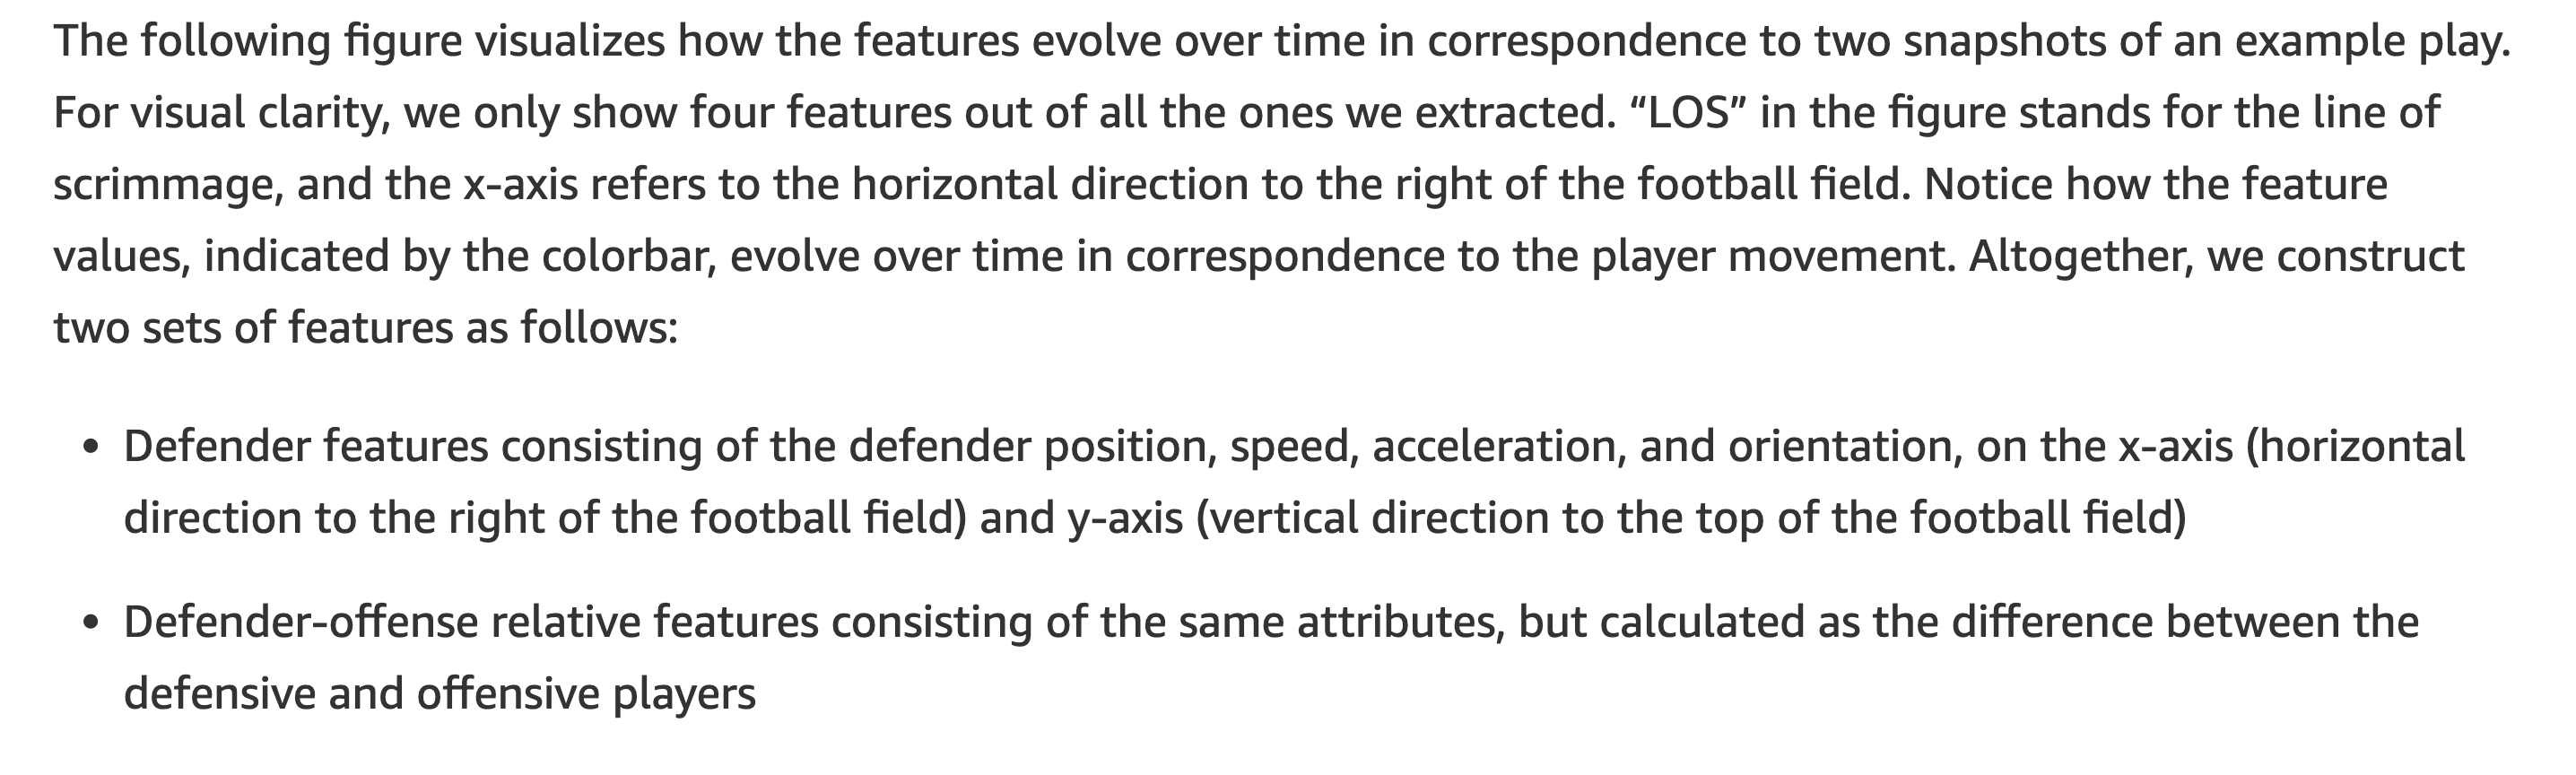

In [41]:
def split_defense_offense(df: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]: 
    ''' turn the original presnap df into the offense and defense presnap'''
    defense = df.filter(pl.col('def') == True)
    offense = df.filter(pl.col('def') != True)
    return defense, offense

In [46]:
def create_player_matrix(players: pl.DataFrame, feature: str, is_defense: bool, def_shape: tuple) -> np.ndarray:

    matrix = np.zeros(def_shape)
    
    for i, player_id in enumerate(players['nflId'].unique()):
        value = players.filter(pl.col('nflId') == player_id)[feature].item()
        if is_defense:
            matrix[i, :] = value  
        else:
            matrix[:, i] = value  
            
    return matrix

In [29]:
def create_relative_matrix(defense: pl.DataFrame, offense: pl.DataFrame, feature: str) -> np.ndarray:
    '''rel diff in features b/w off and def '''
    def_players = defense['nflId'].unique()
    off_players = offense['nflId'].unique()
    
    matrix = np.zeros((len(def_players), len(off_players)))
    for i, def_id in enumerate(def_players):
        def_value = defense.filter(pl.col('nflId') == def_id)[feature].item()
        for j, off_id in enumerate(off_players):
            off_value = offense.filter(pl.col('nflId') == off_id)[feature].item()
            matrix[i, j] = def_value - off_value
    return matrix

In [30]:
def create_motion_matrix(defense: pl.DataFrame, offense: pl.DataFrame) -> np.ndarray:
    '''matrix that indicates whether the offensive player is in motion (bool)'''
    def_players = defense['nflId'].unique()
    off_players = offense['nflId'].unique()
    
    matrix = np.zeros((len(def_players), len(off_players)))
    for j, off_id in enumerate(off_players):
        off_player = offense.filter(pl.col('nflId') == off_id)
        # Player is in motion if any motion indicator is True
        is_motion = any([
            off_player['motionSinceLineset'].item() == 'TRUE',
            off_player['inMotionAtBallSnap'].item() == 'TRUE',
            off_player['shiftSinceLineset'].item() == 'TRUE' # CAN TREAT THIS AS A SEPARTE THING LATER 
        ])
        matrix[:, j] = float(is_motion)
    return matrix

In [ ]:
def create_feature_matrices(defense: pl.DataFrame, offense: pl.DataFrame):
    matrix_shape = (len(defense['nflId'].unique()), len(offense['nflId'].unique()))
    
    def_x = create_player_matrix(defense, 'x', True, matrix_shape)
    def_y = create_player_matrix(defense, 'y', True, matrix_shape)
    def_speed = create_player_matrix(defense, 's', True, matrix_shape)
    def_accel = create_player_matrix(defense, 'a', True, matrix_shape)
    def_orient = create_player_matrix(defense, 'o', True, matrix_shape)
    def_dir = create_player_matrix(defense, 'dir', True, matrix_shape)
    
    off_x = create_player_matrix(offense, 'x', False, matrix_shape)
    off_y = create_player_matrix(offense, 'y', False, matrix_shape)
    off_speed = create_player_matrix(offense, 's', False, matrix_shape)
    off_accel = create_player_matrix(offense, 'a', False, matrix_shape)
    off_orient = create_player_matrix(offense, 'o', False, matrix_shape)
    off_dir = create_player_matrix(offense, 'dir', False, matrix_shape)
    
    rel_x = def_x - off_x
    rel_y = def_y - off_y
    rel_speed = def_speed - off_speed
    rel_accel = def_accel - off_accel
    rel_orient = def_orient - off_orient
    rel_dir = def_dir - off_dir
    
    motion = create_motion_matrix(defense, offense)
    
    return (def_x, def_y, def_speed, def_accel, def_orient, def_dir,
            rel_x, rel_y, rel_speed, rel_accel, rel_orient, rel_dir,
            off_x, off_y, off_speed, off_accel, off_orient, off_dir,
            motion)

ok now need to make the tensor for each play

X process Frame | Play & Game. 

for each frame use the above functions to create the offense and defense matrices + the motion matrix  
then for a given play, need to stitch these frames together by sorting them first to be chronological and then stack them  
then for the entire dataset, we are stackign all these plays together 

In [43]:
def single_frame_process(frame_df):
    defense = frame_df.filter(pl.col('def') == True)
    offense = frame_df.filter(pl.col('def') != True)
    
    matrices = create_feature_matrices(defense, offense)
    
    return np.stack(matrices)  # shape: [19 features, def_players, off_players]

In [33]:
def single_play_process(play_df: pl.DataFrame):
    frame_tensors = []
    
    for frame_id in sorted(play_df['frameId'].unique()):
        frame_data = play_df.filter(pl.col('frameId') == frame_id)
        frame_tensor = single_frame_process(frame_data)
        frame_tensors.append(frame_tensor)
    
    return np.stack(frame_tensors)

In [ ]:
def create_dataset(df: pl.DataFrame):
    play_tensors = []
    labels = []
    
    max_frames = 960  # try other way
    num_features = 19  

    for (game_id, play_id), play_df in df.group_by(['gameId', 'playId']):
        play_frames = []
        
        for frame_id, frame_df in play_df.group_by(['frameId']):
            defense = frame_df.filter(pl.col('def') == True)
            offense = frame_df.filter(pl.col('def') != True)
            
            frame_matrices = create_feature_matrices(defense, offense)
            frame_tensor = np.stack(frame_matrices) 
            play_frames.append(frame_tensor)
            
        actual_frames = len(play_frames)
        play_tensor = np.stack(play_frames) 
        
        def_players = play_tensor.shape[2]
        off_players = play_tensor.shape[3]
        
        padded_play = np.zeros((max_frames, num_features, 11, 11))
        padded_play[:actual_frames, :, :def_players, :off_players] = play_tensor
        play_tensors.append(padded_play)
        
        coverage = play_df['pff_passCoverage'].unique()[0]
        labels.append(coverage)
    
    X = np.stack(play_tensors)
    y = np.array(labels)
    
    return X, y

In [52]:
presnap_sorted

Id,gameId,week,playId,nflId,displayName,frameId,frameType,playDirection,x,y,s,a,dis,o,dir,event,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone,motionSinceLineset,pff_defensiveCoverageAssignment,pff_primaryDefensiveCoverageMatchupNflId,pff_secondaryDefensiveCoverageMatchupNflId,shiftSinceLineset,inMotionAtBallSnap,defensiveTeam,def,absoluteYardlineNumber,yardlineSide,yardlineNumber,x_los
str,i64,i64,i64,i64,str,i64,str,str,f64,f64,f64,f64,f64,f64,f64,str,str,str,i64,str,str,str,str,str,str,str,str,str,bool,i64,str,i64,f64
"""2022090800_1""",2022090800,1,1,35472,"""Rodger Saffold""",76,"""BEFORE_SNAP""","""left""",33.98,25.173333,0.03,0.03,0.01,80.73,103.68,"""line_set""",null,null,0,"""Cover-6""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""BUF""",25,8.98
"""2022090800_1""",2022090800,1,1,42392,"""Mitch Morse""",76,"""BEFORE_SNAP""","""left""",34.54,23.763333,0.05,0.05,0.01,77.55,75.61,"""line_set""",null,null,0,"""Cover-6""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""BUF""",25,9.54
"""2022090800_1""",2022090800,1,1,42489,"""Stefon Diggs""",76,"""BEFORE_SNAP""","""left""",32.98,25.423333,4.49,0.12,0.45,164.97,182.51,"""line_set""",null,null,0,"""Cover-6""","""Zone""","""TRUE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""BUF""",25,7.98
"""2022090800_1""",2022090800,1,1,44875,"""Dion Dawkins""",76,"""BEFORE_SNAP""","""left""",34.01,26.993333,0.02,0.03,0.01,74.87,10.26,"""line_set""",null,null,0,"""Cover-6""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""BUF""",25,9.01
"""2022090800_1""",2022090800,1,1,44985,"""Isaiah McKenzie""",76,"""BEFORE_SNAP""","""left""",33.74,35.163333,0.05,0.03,0.01,80.46,55.32,"""line_set""",null,null,0,"""Cover-6""","""Zone""","""FALSE""","""NA""","""NA""","""NA""","""FALSE""","""FALSE""","""LA""",false,85,"""BUF""",25,8.74
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2022091200_110""",2022091200,1,110,47941,"""Michael Jackson""",90,"""SNAP""","""left""",62.99,11.923333,0.2,0.24,0.02,327.19,180.48,"""ball_snap""",null,null,0,"""Cover-6""","""Zone""","""NA""","""FL""","""52454""","""NA""","""NA""","""NA""","""SEA""",true,65,"""DEN""",45,17.99
"""2022091200_110""",2022091200,1,110,52435,"""Jordyn Brooks""",90,"""SNAP""","""left""",66.15,27.793333,0.07,0.08,0.01,275.83,183.58,"""ball_snap""",null,null,0,"""Cover-6""","""Zone""","""NA""","""HCR""","""NA""","""NA""","""NA""","""NA""","""SEA""",true,65,"""DEN""",45,21.15
"""2022091200_110""",2022091200,1,110,52456,"""Darrell Taylor""",90,"""SNAP""","""left""",56.22,15.433333,0.12,0.41,0.01,304.51,262.44,"""ball_snap""",null,null,0,"""Cover-6""","""Zone""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""SEA""",true,65,"""DEN""",45,11.22


In [59]:
presnap_short = presnap_sorted.filter(pl.col("playId") <= 2)

In [ ]:
presnap_sorted = presnap.sort(['gameId', 'playId', 'frameId'])
X, y = create_dataset(presnap_short)

KeyboardInterrupt: 

In [ ]:
np.save('X_tensor.npy', X)
np.save('y_tensor.npy', y)

In [68]:
np.savez_compressed('tensors.npz', X=X, y=y)
